In [1]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

In [2]:

def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [3]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [4]:
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [5]:
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [6]:
# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
# for i in range(100):
#     print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl


In [7]:
pairs

[['Hi.', 'Hallo!'],
 ['Hi.', 'Grüß Gott!'],
 ['Run!', 'Lauf!'],
 ['Wow!', 'Potzdonner!'],
 ['Wow!', 'Donnerwetter!'],
 ['Fire!', 'Feuer!'],
 ['Help!', 'Hilfe!'],
 ['Help!', 'Zu Hülf!'],
 ['Stop!', 'Stopp!'],
 ['Wait!', 'Warte!'],
 ['Hello!', 'Hallo!'],
 ['I try.', 'Ich probiere es.'],
 ['I won!', 'Ich hab gewonnen!'],
 ['I won!', 'Ich habe gewonnen!'],
 ['Smile.', 'Lächeln!'],
 ['Cheers!', 'Zum Wohl!'],
 ['Freeze!', 'Keine Bewegung!'],
 ['Freeze!', 'Stehenbleiben!'],
 ['Got it?', 'Verstanden?'],
 ['Got it?', 'Einverstanden?'],
 ['He ran.', 'Er rannte.'],
 ['He ran.', 'Er lief.'],
 ['Hop in.', 'Mach mit!'],
 ['Hug me.', 'Drück mich!'],
 ['Hug me.', 'Nimm mich in den Arm!'],
 ['Hug me.', 'Umarme mich!'],
 ['I fell.', 'Ich fiel.'],
 ['I fell.', 'Ich fiel hin.'],
 ['I fell.', 'Ich stürzte.'],
 ['I fell.', 'Ich bin hingefallen.'],
 ['I fell.', 'Ich bin gestürzt.'],
 ['I know.', 'Ich weiß.'],
 ['I lied.', 'Ich habe gelogen.'],
 ['I lost.', 'Ich habe verloren.'],
 ["I'm 19.", 'Ich bin 19 Jahr

In [8]:
raw_dataset = clean_pairs
 
# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


In [9]:
raw_dataset.shape

(152820, 2)

In [10]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [11]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [12]:
from keras.preprocessing.text import Tokenizer

In [13]:
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

English Vocabulary Size: 2404
English Max Length: 5
German Vocabulary Size: 3856
German Max Length: 10


In [14]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [17]:
# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [18]:
trainX[10,:]

array([1069,   22, 1375,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [19]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [20]:
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# summarize defined model

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 256)           987136    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 2404)           617828    
Total params: 2,655,588
Trainable params: 2,655,588
Non-trainable params: 0
_________________________________________________________________
None


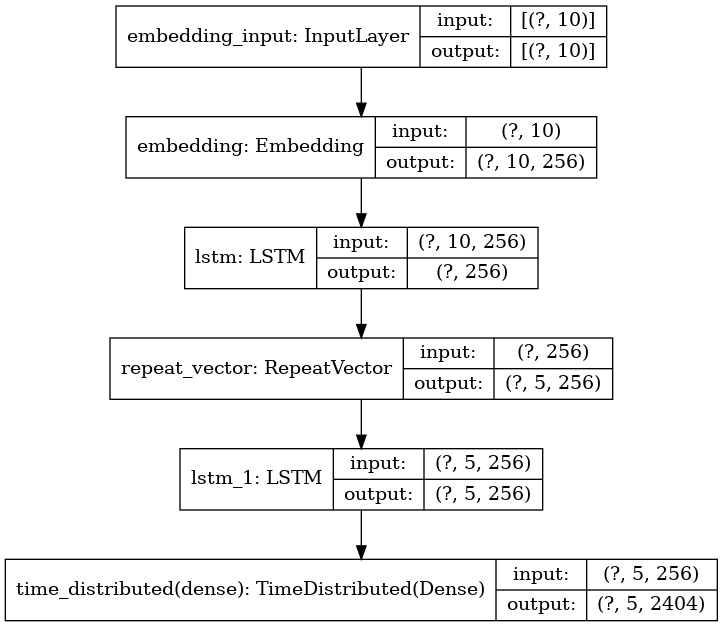

In [22]:
plot_model(model, to_file='german-model.png', show_shapes=True)

In [23]:
filename = 'german_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 3.66297, saving model to german_model.h5
141/141 - 10s - loss: 4.4415 - val_loss: 3.6630
Epoch 2/30

Epoch 00002: val_loss improved from 3.66297 to 3.52549, saving model to german_model.h5
141/141 - 9s - loss: 3.5515 - val_loss: 3.5255
Epoch 3/30

Epoch 00003: val_loss improved from 3.52549 to 3.43481, saving model to german_model.h5
141/141 - 9s - loss: 3.4063 - val_loss: 3.4348
Epoch 4/30

Epoch 00004: val_loss improved from 3.43481 to 3.31356, saving model to german_model.h5
141/141 - 9s - loss: 3.2600 - val_loss: 3.3136
Epoch 5/30

Epoch 00005: val_loss improved from 3.31356 to 3.22685, saving model to german_model.h5
141/141 - 9s - loss: 3.1212 - val_loss: 3.2268
Epoch 6/30

Epoch 00006: val_loss improved from 3.22685 to 3.13251, saving model to german_model.h5
141/141 - 9s - loss: 2.9963 - val_loss: 3.1325
Epoch 7/30

Epoch 00007: val_loss improved from 3.13251 to 3.03374, saving model to german_model.h5
141/141 - 9s - loss: 

In [24]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

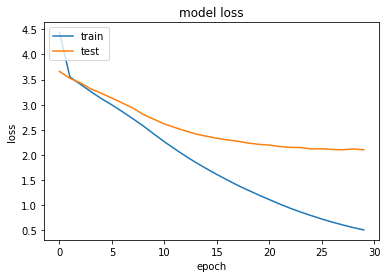

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [26]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))))
	print('BLEU-2: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))))
	print('BLEU-3: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))))
	print('BLEU-4: %.2f' % (100 * corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))))

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[tu ihm nichts], target=[dont hurt him], predicted=[dont hurt him]
src=[das gibts doch nicht], target=[no way], predicted=[no is me]
src=[schau genauer hin], target=[look closer], predicted=[look closer]
src=[ich hasse sie nicht], target=[i dont hate you], predicted=[i dont hate you]
src=[lass tom in ruhe], target=[leave tom alone], predicted=[leave tom alone]
src=[mir geht es genauso], target=[i feel the same], predicted=[i feel the same]
src=[ihr bezahlt], target=[youre paying], predicted=[youre paying]
src=[sie waren bereit], target=[they were ready], predicted=[they were ready]
src=[ich mag pizza], target=[i like pizza], predicted=[i like pizza]
src=[tom setzte sich], target=[tom sat down], predicted=[tom sat down]
BLEU-1: 86.45
BLEU-2: 80.82
BLEU-3: 72.84
BLEU-4: 47.98
test
src=[wie gro bist du], target=[how tall are you], predicted=[how are you you]
src=[er ist ein exknacki], target=[hes an excon], predicted=[he a a]
src=[das ist wichtig], target=[its important], predic